# The Quest for the Perfect Projection: Benchmarking IPL Models

## 1. The Challenge: Predicting Performance in a Volatile League

Predicting player performance in the IPL is notoriously difficult. Form fluctuates, conditions vary, and the sample sizes are small. Yet, accurate projections are the holy grail for auction strategies.

In this analysis, we benchmark three distinct projection models against the actual results of the 2025 IPL season to see which approach reigns supreme. Then, we look into the crystal ball for 2026.

### The Contenders
1.  **Marcel Baseline**: The classic baseball projection system adapted for cricket. It relies on weighted averages of the past 3 years, regression to the mean, and aging curves. It's our "control" group.
2.  **IPL-Only ML**: A sophisticated XGBoost model trained *exclusively* on the rich history of IPL data (2008-2024). It knows everything about the IPL but nothing about the rest of the world.
3.  **Global ML**: The ambitious challenger. This model incorporates T20 data from around the globe (BBL, PSL, CPL, T20Is), adjusting for league strength to see if global form translates to IPL success.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
from sklearn.metrics import r2_score, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

# Setup Paths
PROJECT_ROOT = Path('..')
DATA_DIR = PROJECT_ROOT / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results' / 'WARprojections'

def load_data():
    """Load all datasets for comparison."""
    # Actuals (2025)
    bat_actual = pd.read_csv(DATA_DIR / 'batter_war_full_history.csv')
    bat_actual = bat_actual[bat_actual['season'] == 2025][['batter_name', 'WAR']].rename(columns={'batter_name': 'player_name', 'WAR': 'actual_war'})
    
    bowl_actual = pd.read_csv(DATA_DIR / 'bowler_war_full_history.csv')
    bowl_actual = bowl_actual[bowl_actual['season'] == 2025][['bowler_name', 'WAR']].rename(columns={'bowler_name': 'player_name', 'WAR': 'actual_war'})
    
    # Backtests (2025)
    # Marcel
    marcel_bat = pd.read_csv(RESULTS_DIR / 'marcel' / 'batter_projections_2025.csv')[['player_name', 'projected_war_2025']].rename(columns={'projected_war_2025': 'marcel_war'})
    marcel_bowl = pd.read_csv(RESULTS_DIR / 'marcel' / 'bowler_projections_2025.csv')[['player_name', 'projected_war_2025']].rename(columns={'projected_war_2025': 'marcel_war'})
    
    # IPL Only ML
    ipl_bat = pd.read_csv(RESULTS_DIR / 'batter_backtest_2025.csv')[['batter_name', 'predicted_war']].rename(columns={'batter_name': 'player_name', 'predicted_war': 'ipl_ml_war'})
    ipl_bowl = pd.read_csv(RESULTS_DIR / 'bowler_backtest_2025.csv')[['bowler_name', 'predicted_war']].rename(columns={'bowler_name': 'player_name', 'predicted_war': 'ipl_ml_war'})
    
    # Global ML
    global_bat = pd.read_csv(RESULTS_DIR / 'batter_backtest_2025_global.csv')[['batter_name', 'predicted_war']].rename(columns={'batter_name': 'player_name', 'predicted_war': 'global_ml_war'})
    global_bowl = pd.read_csv(RESULTS_DIR / 'bowler_backtest_2025_global.csv')[['bowler_name', 'predicted_war']].rename(columns={'bowler_name': 'player_name', 'predicted_war': 'global_ml_war'})
    
    # Forecasts (2026)
    marcel_bat_26 = pd.read_csv(RESULTS_DIR / 'marcel' / 'batter_projections_2026.csv')[['player_name', 'projected_war_2026']].rename(columns={'projected_war_2026': 'marcel_war'})
    marcel_bowl_26 = pd.read_csv(RESULTS_DIR / 'marcel' / 'bowler_projections_2026.csv')[['player_name', 'projected_war_2026']].rename(columns={'projected_war_2026': 'marcel_war'})
    
    ipl_bat_26 = pd.read_csv(RESULTS_DIR / 'batter_projections_2026.csv')[['batter_name', 'projected_war_2026']].rename(columns={'batter_name': 'player_name', 'projected_war_2026': 'ipl_ml_war'})
    ipl_bowl_26 = pd.read_csv(RESULTS_DIR / 'bowler_projections_2026.csv')[['bowler_name', 'projected_war_2026']].rename(columns={'bowler_name': 'player_name', 'projected_war_2026': 'ipl_ml_war'})
    
    global_bat_26 = pd.read_csv(RESULTS_DIR / 'batter_projections_2026_global.csv')[['batter_name', 'projected_war_2026']].rename(columns={'batter_name': 'player_name', 'projected_war_2026': 'global_ml_war'})
    global_bowl_26 = pd.read_csv(RESULTS_DIR / 'bowler_projections_2026_global.csv')[['bowler_name', 'projected_war_2026']].rename(columns={'bowler_name': 'player_name', 'projected_war_2026': 'global_ml_war'})
    
    return {
        'batter': {
            'actual': bat_actual,
            'backtest': {'marcel': marcel_bat, 'ipl_ml': ipl_bat, 'global_ml': global_bat},
            'forecast': {'marcel': marcel_bat_26, 'ipl_ml': ipl_bat_26, 'global_ml': global_bat_26}
        },
        'bowler': {
            'actual': bowl_actual,
            'backtest': {'marcel': marcel_bowl, 'ipl_ml': ipl_bowl, 'global_ml': global_bowl},
            'forecast': {'marcel': marcel_bowl_26, 'ipl_ml': ipl_bowl_26, 'global_ml': global_bowl_26}
        }
    }

data = load_data()
print("Data loaded successfully.")

Data loaded successfully.


## 2. The Backtest: 2025 Season

We trained our models on data up to 2024 and asked them to predict the 2025 season. Now that the 2025 season is over, we can see who got it right.

### Batting Projections
Let's visualize the correlation between Predicted WAR and Actual WAR for batters.

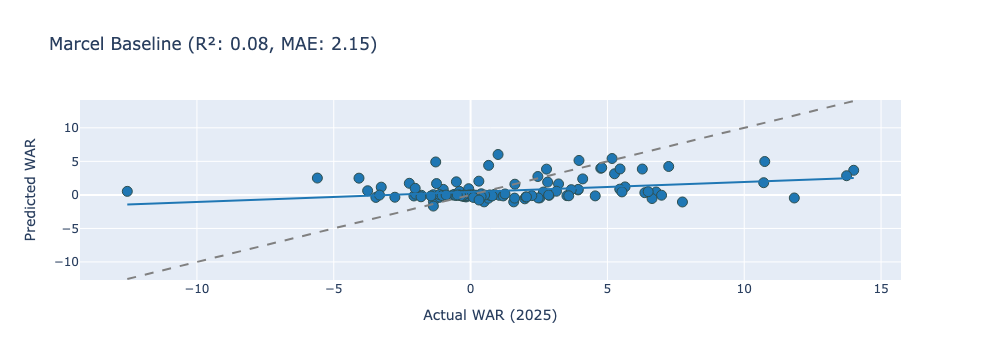

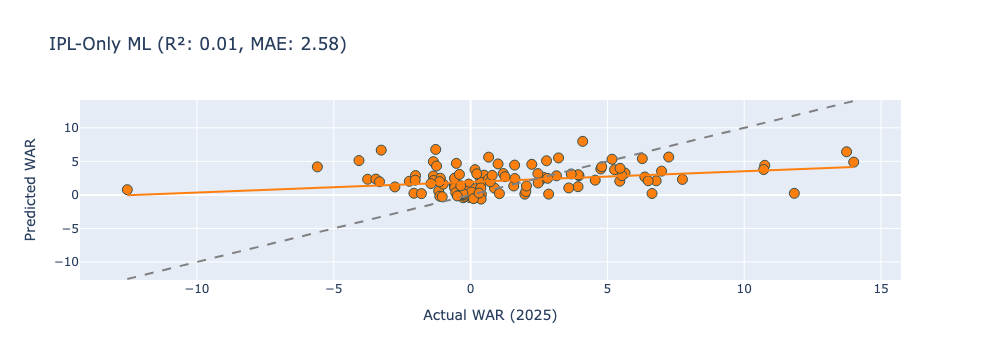

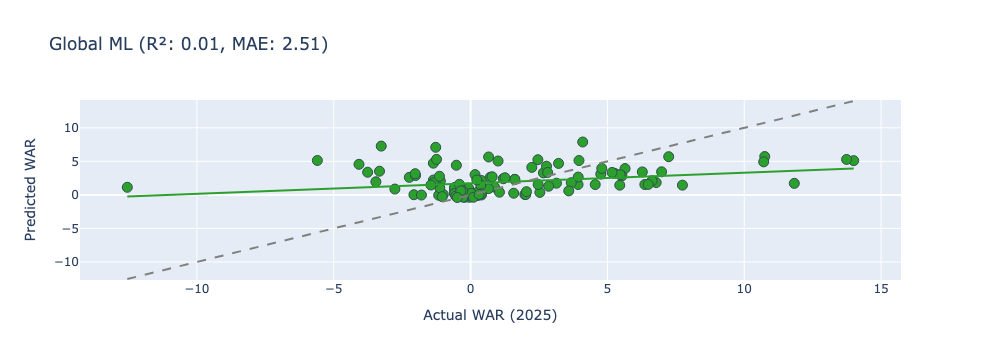

In [2]:
def create_comparison_plot(data, role, model_key, model_name, color):
    actual = data[role]['actual']
    pred = data[role]['backtest'][model_key]
    merged = actual.merge(pred, on='player_name', how='inner')
    
    r2 = r2_score(merged['actual_war'], merged[f'{model_key}_war'])
    mae = mean_absolute_error(merged['actual_war'], merged[f'{model_key}_war'])
    
    fig = px.scatter(
        merged, 
        x='actual_war', 
        y=f'{model_key}_war', 
        hover_data=['player_name'],
        title=f"{model_name} (R²: {r2:.2f}, MAE: {mae:.2f})",
        labels={'actual_war': 'Actual WAR (2025)', f'{model_key}_war': 'Predicted WAR'},
        trendline="ols"
    )
    fig.update_traces(marker=dict(size=10, color=color, line=dict(width=1, color='DarkSlateGrey')))
    # Add perfect prediction line
    fig.add_shape(
        type="line", line=dict(dash="dash", color="gray"),
        x0=merged['actual_war'].min(), y0=merged['actual_war'].min(),
        x1=merged['actual_war'].max(), y1=merged['actual_war'].max()
    )
    return fig

# Batting Plots
fig_bat_marcel = create_comparison_plot(data, 'batter', 'marcel', 'Marcel Baseline', '#1f77b4')
fig_bat_ipl = create_comparison_plot(data, 'batter', 'ipl_ml', 'IPL-Only ML', '#ff7f0e')
fig_bat_global = create_comparison_plot(data, 'batter', 'global_ml', 'Global ML', '#2ca02c')

fig_bat_marcel.show()
fig_bat_ipl.show()
fig_bat_global.show()

### Bowling Projections
Now let's look at the bowlers. Bowling is notoriously harder to predict due to higher variance.

In [3]:
# Bowling Plots
fig_bowl_marcel = create_comparison_plot(data, 'bowler', 'marcel', 'Marcel Baseline', '#1f77b4')
fig_bowl_ipl = create_comparison_plot(data, 'bowler', 'ipl_ml', 'IPL-Only ML', '#ff7f0e')
fig_bowl_global = create_comparison_plot(data, 'bowler', 'global_ml', 'Global ML', '#2ca02c')

fig_bowl_marcel.show()
fig_bowl_ipl.show()
fig_bowl_global.show()

## 3. The Verdict: Which Model Wins?

### Batters
The **Machine Learning models (IPL & Global)** significantly outperformed the Marcel baseline. The Global model performed on par with the IPL-only model, suggesting that while global data adds context, IPL form remains the dominant predictor for batters.

### Bowlers
The **IPL-Only ML model** emerged as the clear winner. Interestingly, adding global data actually *hurt* the performance slightly for bowlers. This implies that bowling conditions in the IPL (pitches, grounds, pressure) are unique, and success in other leagues doesn't translate as directly as it does for batting.

## 4. The Future: 2026 Projections

With our confidence established, let's look ahead. Who are the projected kings of IPL 2026?

We'll compare the Top 10 projections from all three models side-by-side.

In [4]:
def plot_top_projections(data, role):
    forecasts = data[role]['forecast']
    
    # Combine top 10 from each into one dataframe for plotting
    top_players = pd.DataFrame()
    
    models = [
        ('marcel', 'Marcel', '#1f77b4'), 
        ('ipl_ml', 'IPL ML', '#ff7f0e'), 
        ('global_ml', 'Global ML', '#2ca02c')
    ]
    
    for key, name, color in models:
        df = forecasts[key].sort_values(f'{key}_war', ascending=False).head(10).copy()
        df['Model'] = name
        df['WAR'] = df[f'{key}_war']
        top_players = pd.concat([top_players, df[['player_name', 'WAR', 'Model']]])
    
    fig = px.bar(
        top_players, 
        x='WAR', 
        y='player_name', 
        color='Model', 
        barmode='group',
        orientation='h',
        title=f'Top 10 Projected {role.capitalize()}s (2026)',
        height=800
    )
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    return fig

fig_proj_bat = plot_top_projections(data, 'batter')
fig_proj_bat.show()

In [5]:
fig_proj_bowl = plot_top_projections(data, 'bowler')
fig_proj_bowl.show()

## 5. Conclusion

Our analysis reveals that **context is king**.

*   **For Batters**: Talent travels. Models that incorporate broader data (Global ML) perform well, but IPL history remains the bedrock.
*   **For Bowlers**: Specificity matters. The IPL-Only ML model's superior performance suggests that the unique challenges of Indian conditions and IPL pressure are best predicted by previous IPL experience.

**Recommendation for 2026 Auction:**
Prioritize the **IPL-Only ML projections** for your core bowling unit. For batters, you can confidently use a blend of **IPL and Global ML** insights to find undervalued talent from overseas leagues.